In [1]:
import os
import glob
import re
import datetime
from datetime import date, time, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from cv2 import VideoCapture, CAP_PROP_FRAME_COUNT, CAP_PROP_FPS, CAP_PROP_POS_FRAMES
import ffmpeg
from imutils.video import FileVideoStream
import time
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, export_png, export_svg
from bokeh.models import Span, DatetimeTicker, DatetimeTickFormatter
from utils import load_diffs, load_slide_changes, load_intervals, filter_video, plot_slide_diffs

sns.set()
output_notebook()

Loading BokehJS ...

# Paths

In [2]:
#meeting_id = 160320
#meeting_id = 220120
#meeting_id = 170127
meeting_id = 83512718053

In [3]:
masked = None

In [4]:
video_path = glob.glob(f'zoom_data/{meeting_id}/*.mp4')[0]
print(video_path)
if masked is None:
    diff_path = f'diff_data/diffs_{meeting_id}_cossim.csv'
    diff_path_masked = f'diff_data/diffs_{meeting_id}_pct_masked_cossim.csv'
elif masked:
    diff_path = f'diff_data/diffs_{meeting_id}_pct_masked_cossim.csv'
else:
    diff_path = f'diff_data/diffs_{meeting_id}_cossim.csv'
sc_labels = f'slide_change_labels/{meeting_id}.csv'
interval_path = 'interval_data/intervals.csv'

zoom_data/83512718053/GMT20210527-002121_Recording_1920x1200.mp4


# Load FPS, Diffs, and Slide Change Labels

In [5]:
vidcap = VideoCapture(video_path)
fps = vidcap.get(CAP_PROP_FPS)
ddiffs = load_diffs(diff_path, fps)
if masked != False:
    ddiffs_masked = load_diffs(diff_path_masked, fps)
sldf = load_slide_changes(sc_labels)
idf = load_intervals(interval_path, meeting_id=meeting_id)
ddiffs = filter_video(ddiffs, idf)
if masked != False:
    ddiffs_masked = filter_video(ddiffs_masked, idf)

In [6]:
'''
meeting_id = 160320
video_file = 'GMT20210614-160320_Recording_2020x1380.mp4'
#meeting_id = 83512718053
#video_file = 'GMT20210527-002121_Recording_1920x1200.mp4'
video_path = f'zoom_data/{meeting_id}/{video_file}'
#diff_path = f'diffs_{meeting_id}.csv'
diff_path = f'diff_data/diffs_{meeting_id}_cossim.csv'
sc_labels = f'slide_change_labels/{meeting_id}.csv'
'''

"\nmeeting_id = 160320\nvideo_file = 'GMT20210614-160320_Recording_2020x1380.mp4'\n#meeting_id = 83512718053\n#video_file = 'GMT20210527-002121_Recording_1920x1200.mp4'\nvideo_path = f'zoom_data/{meeting_id}/{video_file}'\n#diff_path = f'diffs_{meeting_id}.csv'\ndiff_path = f'diff_data/diffs_{meeting_id}_cossim.csv'\nsc_labels = f'slide_change_labels/{meeting_id}.csv'\n"

# Inspect Diff Stages

In [7]:
diffs = pd.read_csv(diff_path)
diffs['cos_sim'] = 1 - diffs.cos_sim   # Invert
diffs['second'] = diffs.index.to_numpy() // fps  # Discretize
diffs

,l1,l2,cos_sim,meeting_id,second
0,0.0,0.000000,1.000000e+00,83512718053,0.0
1,0.0,0.000000,1.000000e+00,83512718053,0.0
2,0.0,0.000000,1.000000e+00,83512718053,0.0
3,0.0,0.000000,1.000000e+00,83512718053,0.0
4,0.0,0.000000,1.000000e+00,83512718053,0.0
...,...,...,...,...,...
63475,79663997.0,141295.874798,5.361174e-05,83512718053,2539.0
63476,2786968.0,26559.369721,4.028041e-07,83512718053,2539.0
63477,23992.0,2446.103841,7.739612e-09,83512718053,2539.0
63478,58092951.0,120872.145455,2.354526e-05,83512718053,2539.0


### Raw

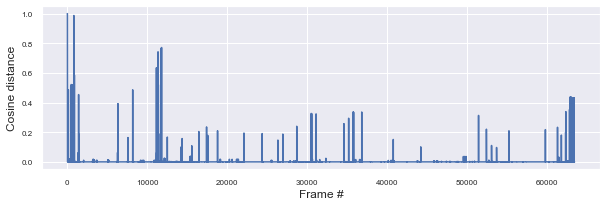

In [16]:
ax = diffs.cos_sim.plot(figsize=(10, 3), 
                        xlabel='Frame #', 
                        ylabel='Cosine distance', 
                        fontsize=8)
plt.savefig("thesis/mscs_thesis/figures/2_3_invcossim.pdf", dpi=300, bbox_inches='tight')
#ax.set_ylabel(ax.get_ylabel(), fontsize=15)
#ax.set_xlabel(ax.get_xlabel(), fontsize=15);

### Aggregate to second level (discretized diffs)
Take the max value over all frames in each second, then add timestamps

In [8]:
ddiffs = diffs.groupby(['meeting_id', 'second'], as_index=False)[['l1', 'l2', 'cos_sim']].max()
ddiffs['l1_diff'] = np.maximum(ddiffs.l1.diff(), 0)
ddiffs['l2_diff'] = np.maximum(ddiffs.l2.diff(), 0)
ddiffs['cos_sim_diff'] = np.maximum(ddiffs.cos_sim.diff(), 0)
ddiffs['elapsed'] = pd.to_datetime(ddiffs.second, unit='s').dt.strftime('%H:%M:%S')
ddiffs['elapsed_dt'] = pd.to_datetime(ddiffs.second, unit='s')
ddiffs

,meeting_id,second,l1,l2,cos_sim,l1_diff,l2_diff,cos_sim_diff,elapsed,elapsed_dt
0,83512718053,0.0,361509646.0,252540.767818,1.000000,NaN,NaN,NaN,00:00:00,1970-01-01 00:00:00
1,83512718053,1.0,83428296.0,144812.121205,0.000115,0.0,0.000000,0.000000e+00,00:00:01,1970-01-01 00:00:01
2,83512718053,2.0,82241652.0,144040.717084,0.000166,0.0,0.000000,5.102081e-05,00:00:02,1970-01-01 00:00:02
3,83512718053,3.0,90918207.0,151380.533653,0.000167,8676555.0,7339.816569,7.922477e-07,00:00:03,1970-01-01 00:00:03
4,83512718053,4.0,95320759.0,154405.263392,0.000223,4402552.0,3024.729739,5.646337e-05,00:00:04,1970-01-01 00:00:04
...,...,...,...,...,...,...,...,...,...,...
2535,83512718053,2535.0,194705127.0,220684.065730,0.000202,0.0,0.000000,0.000000e+00,00:42:15,1970-01-01 00:42:15
2536,83512718053,2536.0,712183408.0,335703.109604,0.432555,517478281.0,115019.043875,4.323530e-01,00:42:16,1970-01-01 00:42:16
2537,83512718053,2537.0,434503229.0,329161.600775,0.002089,0.0,0.000000,0.000000e+00,00:42:17,1970-01-01 00:42:17
2538,83512718053,2538.0,143366127.0,189548.610327,0.000174,0.0,0.000000,0.000000e+00,00:42:18,1970-01-01 00:42:18


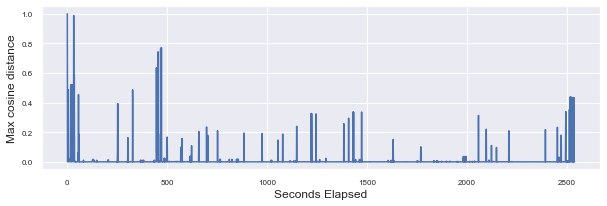

In [17]:
ddiffs.cos_sim.plot(figsize=(10, 3), 
                    xlabel='Seconds Elapsed', 
                    ylabel='Max cosine distance', 
                    fontsize=8)
plt.savefig("thesis/mscs_thesis/figures/2_3_minvcossim.pdf", dpi=300, bbox_inches='tight')

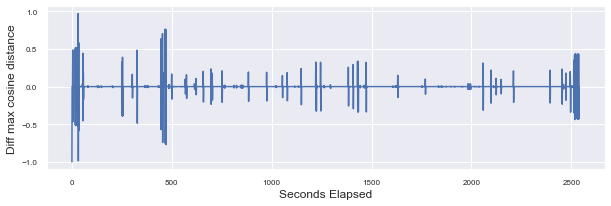

In [18]:
ddiffs.cos_sim.diff().plot(figsize=(10, 3), 
                            xlabel='Seconds Elapsed', 
                            ylabel='Diff max cosine distance', 
                            fontsize=8)
plt.savefig("thesis/mscs_thesis/figures/2_3_minvcossimdiff.pdf", dpi=300, bbox_inches='tight')

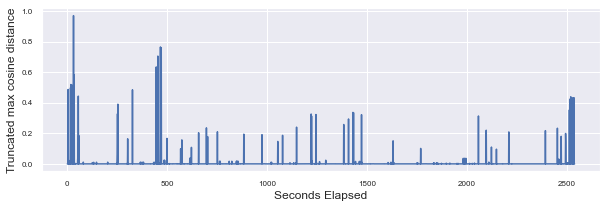

In [19]:
ddiffs.cos_sim_diff.plot(figsize=(10, 3), 
                         xlabel='Seconds Elapsed', 
                         ylabel='Truncated max cosine distance', 
                         fontsize=8)
plt.savefig("thesis/mscs_thesis/figures/2_3_minvcossimdifftrunc.pdf", dpi=300, bbox_inches='tight')

# Load Slide Change Labels

In [9]:
sldf = None
if os.path.exists(sc_labels):
    sldf = pd.read_csv(sc_labels)
    sldf['change_time_dt'] = pd.to_datetime('1970-01-01' + ' ' + sldf.change_time, format='%Y-%m-%d %M:%S')
    sldf.head()

# Visualize

In [14]:
ddiffs

,meeting_id,second,l1,l2,cos_sim,l1_diff,l2_diff,cos_sim_diff,elapsed,elapsed_dt
0,83512718053,0.0,361509646.0,252540.767818,1.000000,NaN,NaN,NaN,00:00:00,1970-01-01 00:00:00
1,83512718053,1.0,83428296.0,144812.121205,0.000115,0.0,0.000000,0.000000e+00,00:00:01,1970-01-01 00:00:01
2,83512718053,2.0,82241652.0,144040.717084,0.000166,0.0,0.000000,5.102081e-05,00:00:02,1970-01-01 00:00:02
3,83512718053,3.0,90918207.0,151380.533653,0.000167,8676555.0,7339.816569,7.922477e-07,00:00:03,1970-01-01 00:00:03
4,83512718053,4.0,95320759.0,154405.263392,0.000223,4402552.0,3024.729739,5.646337e-05,00:00:04,1970-01-01 00:00:04
...,...,...,...,...,...,...,...,...,...,...
2535,83512718053,2535.0,194705127.0,220684.065730,0.000202,0.0,0.000000,0.000000e+00,00:42:15,1970-01-01 00:42:15
2536,83512718053,2536.0,712183408.0,335703.109604,0.432555,517478281.0,115019.043875,4.323530e-01,00:42:16,1970-01-01 00:42:16
2537,83512718053,2537.0,434503229.0,329161.600775,0.002089,0.0,0.000000,0.000000e+00,00:42:17,1970-01-01 00:42:17
2538,83512718053,2538.0,143366127.0,189548.610327,0.000174,0.0,0.000000,0.000000e+00,00:42:18,1970-01-01 00:42:18


In [10]:
#ddiffs = ddiffs.loc[(ddiffs.elapsed_dt >= sldf.change_time_dt.min()) & (ddiffs.elapsed_dt <= sldf.change_time_dt.max()), :]
diffs_l1 = diffs.l1.to_numpy()
diffs_l2 = diffs.l2.to_numpy()
diffs_cos = diffs.cos_sim.to_numpy()
ddiffs_l1 = ddiffs.l1.to_numpy()
ddiffs_l2 = ddiffs.l2.to_numpy()
ddiffs_cos = ddiffs.cos_sim.to_numpy()
ddiffs_time = ddiffs.elapsed_dt

In [23]:
pkw_args = dict(plot_width=3000, plot_height=700, x_axis_type='datetime')
p = plot_slide_diffs(ddiffs, sldf=sldf, score_type='l2', fig_kwargs=pkw_args)
p.title.text = ""
#p.title.text_font_size = '15pt'
p.legend.visible = False
p.xaxis.axis_label = "Elapsed Time"
p.xaxis.axis_label_text_font_size = "50pt"
p.yaxis.axis_label = "L2 Norm (diff)"
p.yaxis.axis_label_text_font_size = "50pt"
#r = export_svg(p, filename="thesis/mscs_thesis/figures/3_2_1_l2norm.svg")
#print(r)
export_png(p, filename="thesis/mscs_thesis/figures/3_2_1_l2norm.png")
#show(p)

'/Users/jackcan/repos/tlab/thesis/mscs_thesis/figures/3_2_1_l2norm.png'

In [24]:
p = plot_slide_diffs(ddiffs, sldf=sldf)
#p.title.text = "Cosine Distance (unmasked)"
p.title.text = ""
#p.title.text_font_size = '15pt'
p.legend.visible = False
p.xaxis.axis_label = "Elapsed Time"
p.xaxis.axis_label_text_font_size = "20pt"
p.yaxis.axis_label = "Cosine Distance (diff)"
p.yaxis.axis_label_text_font_size = "20pt"
p.output_backend = "svg"
export_svg(p, filename="thesis/mscs_thesis/figures/3_2_cossimunmasked.svg")
show(p)

In [25]:
p = plot_slide_diffs(ddiffs_masked, sldf=sldf)
#p.title.text = "Inverse Cosine Similarity (masked)"
#p.title.text_font_size = '15pt'
p.title.text = ""
p.legend.visible = False
p.xaxis.axis_label = "Elapsed Time"
p.xaxis.axis_label_text_font_size = "20pt"
p.yaxis.axis_label = "Cosine Distance (diff)"
p.yaxis.axis_label_text_font_size = "20pt"
p.output_backend = "svg"
export_svg(p, filename="thesis/mscs_thesis/figures/3_2_1cossimmasked.svg")
show(p)

### Cosine Similarly

In [47]:
p = figure(plot_width=1500, plot_height=400)
p.line(range(len(diffs_cos)), diffs_cos, line_width=2, line_alpha=0.5)
median = Span(location=np.median(diffs_cos), dimension='width', line_color='black', line_dash='dashed', line_width=1)
sdev = Span(location=np.median(diffs_cos) + np.std(diffs_cos), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev2 = Span(location=np.median(diffs_cos) + 2 * np.std(diffs_cos), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev3 = Span(location=np.median(diffs_cos) + 3 * np.std(diffs_cos), dimension='width', line_color='red', line_dash='dashed', line_width=1)
p.add_layout(median)
p.add_layout(sdev)
p.add_layout(sdev2)
p.add_layout(sdev3)
p.title.text = "Frame diffs - cosine similarity"
p.title.text_font_size = '15pt'
show(p)

#### Before Mask

In [48]:
p = figure(plot_width=1500, plot_height=400, x_axis_type='datetime')
p.line(ddiffs_time, ddiffs_cos, line_width=2, line_alpha=0.5)
median = Span(location=np.median(ddiffs_cos), dimension='width', line_color='black', line_dash='dashed', line_width=1)
sdev = Span(location=np.median(ddiffs_cos) + np.std(ddiffs_cos), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev2 = Span(location=np.median(ddiffs_cos) + 2 * np.std(ddiffs_cos), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev3 = Span(location=np.median(ddiffs_cos) + 3 * np.std(ddiffs_cos), dimension='width', line_color='red', line_dash='dashed', line_width=1)
p.add_layout(median)
p.add_layout(sdev)
p.add_layout(sdev2)
p.add_layout(sdev3)

if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)

p.title.text = "Frame diffs (binned) - cosine similarity"
p.title.text_font_size = '15pt'
#p.xaxis.ticker.desired_num_ticks = 40
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%M', seconds='%M:%S')
p.xaxis.major_label_orientation = "vertical"
show(p)

#### After Mask

In [61]:
ddiffs = ddiffs_masked.loc[(ddiffs_masked.elapsed_dt >= sldf.change_time_dt.min()) & (ddiffs_masked.elapsed_dt <= sldf.change_time_dt.max()), :]
diffs_l1 = diffs.l1.to_numpy()
diffs_l2 = diffs.l2.to_numpy()
diffs_cos = diffs.cos_sim.to_numpy()
ddiffs_l1 = ddiffs.l1.to_numpy()
ddiffs_l2 = ddiffs.l2.to_numpy()
ddiffs_cos = ddiffs.cos_sim.to_numpy()
ddiffs_time = ddiffs.elapsed_dt

AttributeError: 'DataFrame' object has no attribute 'l1'

### L1 Norm

In [44]:
p = figure(plot_width=1500, plot_height=400)
p.line(range(len(diffs_l1)), diffs_l1, line_width=2, line_alpha=0.5)
median = Span(location=np.median(diffs_l1), dimension='width', line_color='black', line_dash='dashed', line_width=1)
sdev = Span(location=np.median(diffs_l1) + np.std(diffs_l1), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev2 = Span(location=np.median(diffs_l1) + 2 * np.std(diffs_l1), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev3 = Span(location=np.median(diffs_l1) + 3 * np.std(diffs_l1), dimension='width', line_color='red', line_dash='dashed', line_width=1)
p.add_layout(median)
p.add_layout(sdev)
p.add_layout(sdev2)
p.add_layout(sdev3)
p.title.text = "Frame diffs - L1 norm"
p.title.text_font_size = '15pt'
show(p)

### Before mask

In [45]:
p = figure(plot_width=1500, plot_height=400, x_axis_type='datetime')
p.line(ddiffs_time, ddiffs_l1, line_width=2, line_alpha=0.5)
median = Span(location=np.median(ddiffs_l1), dimension='width', line_color='black', line_dash='dashed', line_width=1)
sdev = Span(location=np.median(ddiffs_l1) + np.std(ddiffs_l1), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev2 = Span(location=np.median(ddiffs_l1) + 2 * np.std(ddiffs_l1), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev3 = Span(location=np.median(ddiffs_l1) + 3 * np.std(ddiffs_l1), dimension='width', line_color='red', line_dash='dashed', line_width=1)
p.add_layout(median)
p.add_layout(sdev)
p.add_layout(sdev2)
p.add_layout(sdev3)

if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)

p.title.text = "Frame diffs (binned) - L1 norm"
p.title.text_font_size = '15pt'
#p.xaxis.ticker.desired_num_ticks = 40
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%M', seconds='%M:%S')
p.xaxis.major_label_orientation = "vertical"
show(p)

### After mask (still need to verify it was done correctly)

In [46]:
p = figure(plot_width=1500, plot_height=400, x_axis_type='datetime')
p.line(ddiffs_time, ddiffs_l1, line_width=2, line_alpha=0.5)
median = Span(location=np.median(ddiffs_l1), dimension='width', line_color='black', line_dash='dashed', line_width=1)
sdev = Span(location=np.median(ddiffs_l1) + np.std(ddiffs_l1), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev2 = Span(location=np.median(ddiffs_l1) + 2 * np.std(ddiffs_l1), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev3 = Span(location=np.median(ddiffs_l1) + 3 * np.std(ddiffs_l1), dimension='width', line_color='red', line_dash='dashed', line_width=1)
p.add_layout(median)
p.add_layout(sdev)
p.add_layout(sdev2)
p.add_layout(sdev3)

if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)

p.title.text = "Frame diffs (binned) - L1 norm"
p.title.text_font_size = '15pt'
#p.xaxis.ticker.desired_num_ticks = 40
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%M', seconds='%M:%S')
p.xaxis.major_label_orientation = "vertical"
show(p)

### L2 Norm

In [41]:
p = figure(plot_width=1500, plot_height=400)
p.line(range(len(diffs_l2)), diffs_l2, line_width=2, line_alpha=0.5)
median = Span(location=np.median(diffs_l2), dimension='width', line_color='black', line_dash='dashed', line_width=1)
sdev = Span(location=np.median(diffs_l2) + np.std(diffs_l2), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev2 = Span(location=np.median(diffs_l2) + 2 * np.std(diffs_l2), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev3 = Span(location=np.median(diffs_l2) + 3 * np.std(diffs_l2), dimension='width', line_color='red', line_dash='dashed', line_width=1)
p.add_layout(median)
p.add_layout(sdev)
p.add_layout(sdev2)
p.add_layout(sdev3)

p.title.text = "Frame diffs - L2 norm"
p.title.text_font_size = '15pt'
show(p)

### Before mask

In [42]:
p = figure(plot_width=1500, plot_height=400, x_axis_type='datetime')
p.line(ddiffs_time, ddiffs_l2, line_width=2, line_alpha=0.5)
median = Span(location=np.median(ddiffs_l2), dimension='width', line_color='black', line_dash='dashed', line_width=1)
sdev = Span(location=np.median(ddiffs_l2) + np.std(ddiffs_l2), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev2 = Span(location=np.median(ddiffs_l2) + 2 * np.std(ddiffs_l2), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev3 = Span(location=np.median(ddiffs_l2) + 3 * np.std(ddiffs_l2), dimension='width', line_color='red', line_dash='dashed', line_width=1)
p.add_layout(median)
p.add_layout(sdev)
p.add_layout(sdev2)
p.add_layout(sdev3)

if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)

p.title.text = "Frame diffs (binned) - L2 norm"
p.title.text_font_size = '15pt'
#p.xaxis.ticker.desired_num_ticks = 40
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%M', seconds='%M:%S')
p.xaxis.major_label_orientation = "vertical"
show(p)

### After mask

In [43]:
p = figure(plot_width=1500, plot_height=400, x_axis_type='datetime')
p.line(ddiffs_time, ddiffs_l2, line_width=2, line_alpha=0.5)
median = Span(location=np.median(ddiffs_l2), dimension='width', line_color='black', line_dash='dashed', line_width=1)
sdev = Span(location=np.median(ddiffs_l2) + np.std(ddiffs_l2), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev2 = Span(location=np.median(ddiffs_l2) + 2 * np.std(ddiffs_l2), dimension='width', line_color='red', line_dash='dashed', line_width=1)
sdev3 = Span(location=np.median(ddiffs_l2) + 3 * np.std(ddiffs_l2), dimension='width', line_color='red', line_dash='dashed', line_width=1)
p.add_layout(median)
p.add_layout(sdev)
p.add_layout(sdev2)
p.add_layout(sdev3)

if sldf is not None:
    for sc in sldf.change_time_dt:
        c = Span(location=sc, dimension='height', line_color='black', line_width=0.5)
        p.add_layout(c)

p.title.text = "Frame diffs (binned) - L2 norm"
p.title.text_font_size = '15pt'
#p.xaxis.ticker.desired_num_ticks = 40
p.xaxis.ticker = DatetimeTicker(desired_num_ticks=30, num_minor_ticks=10)
p.xaxis.formatter = DatetimeTickFormatter(minutes='%M', seconds='%M:%S')
p.xaxis.major_label_orientation = "vertical"
show(p)

# Notes

* Having performance issues - looking into a solution
  * Do I need all 3 channels?
  * Do I need color?
* Started with naive outlier detector (low-hanging fruit)
  * Based on standard deviations
  * Can research time-series models and more sophisticated techniques
* Discretize to 1 second bins?
  * Take max diff in the time window
* Further questions
  * Performance issues when analyzing many meetings - should I just assume analysis is for a single meeting?
  * Research question
    * Is this expected to be tested? Or is this more of a hypothetical question, assuming we had data for many classroom sessions? 

* Manually label slide changes
* Can also use background noise removal algo for removing noise from cameras in video screen
* Can we get a signature for each slide
  * For tracking how many times we visit a given slide
  * How many slides have been seen more than once
  * Related to OCR task - can use for signature
  * Add card for this
* Research question is more for evaluating tool's performance
  * Test 2/3 sessions
  * To test, need test lectures, with requirements;
    * Transcript
    * Video
    * Other